In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ModuleNotFoundError: No module named 'config_copy' (or 'config')
# from config_copy import geoapify_key
# Hard code in geoapify_key for now:
geoapify_key  = 'ba9029bb005d4d71a53d7b8740cb6ea6'

import json
import requests
import requests,re,io
from bs4 import BeautifulSoup
from pprint import pprint
import hvplot.pandas

import plotly.graph_objs as go
import ipywidgets as widgets
import plotly.express as px



In [74]:
# Priya's API pull for data.ny.gov - ./Resources/Annual_Pop_and_Density_by_County_beginning_1970.csv

In [75]:
# Read Data.ny.gov data in to popdenscounty dataframe from CSV

popdenscounty=pd.read_csv("./Resources/Annual_Pop_and_Density_by_County_beginning_1970.csv")
print(popdenscounty)

      FIPS Code      Geography  Year                     Program Type  \
0         36001  Albany County  1970  Intercensal Population Estimate   
1         36001  Albany County  1971  Intercensal Population Estimate   
2         36001  Albany County  1972  Intercensal Population Estimate   
3         36001  Albany County  1973  Intercensal Population Estimate   
4         36001  Albany County  1974  Intercensal Population Estimate   
...         ...            ...   ...                              ...   
3649      36123   Yates County  2017   Postcensal Population Estimate   
3650      36123   Yates County  2018   Postcensal Population Estimate   
3651      36123   Yates County  2019   Postcensal Population Estimate   
3652      36123   Yates County  2020   Postcensal Population Estimate   
3653      36123   Yates County  2021   Postcensal Population Estimate   

      Population  
0         287114  
1         288615  
2         290302  
3         289754  
4         289148  
...      

In [76]:
# Create list of unique FIPS Codes for use with land area dataframe in next step

fipscodes = []

for i in range(len(popdenscounty['FIPS Code'])):
    if popdenscounty.iat[i,0] in fipscodes:
        pass
    else:
        fipscodes.append(popdenscounty.iat[i,0])

print(fipscodes)


[36001, 36003, 36005, 36007, 36009, 36011, 36013, 36015, 36017, 36019, 36021, 36023, 36025, 36027, 36029, 36031, 36033, 36035, 36037, 36039, 36041, 36043, 36045, 36047, 36049, 36051, 36053, 36055, 36057, 36059, 36061, 36000, 36063, 36065, 36067, 36069, 36071, 36073, 36075, 36077, 36079, 36081, 36083, 36085, 36087, 36091, 36093, 36095, 36097, 36099, 36089, 36101, 36103, 36105, 36107, 36109, 36111, 36113, 36115, 36117, 36119, 36121, 36123]


In [77]:
# Priya's api/web data code - "./Resources/health.ny.gov_table02.csv"

In [78]:
# Read Health.ny.gov data into dataframe from CSV
landareacounty=pd.read_csv("./Resources/health.ny.gov_table02.csv")
landareacounty=pd.DataFrame(landareacounty)
print(landareacounty)

            County 2018 Population Estimate 2010 Census Population  \
0   New York State               19,542,209             19,378,102   
1    New York City                8,398,748              8,175,133   
2            Bronx                1,432,132              1,385,108   
3            Kings                2,582,830              2,504,700   
4         New York                1,628,701              1,585,873   
..             ...                      ...                    ...   
59      Washington                   61,197                 63,216   
60           Wayne                   90,064                 93,772   
61     Westchester                  967,612                949,113   
62         Wyoming                   40,085                 42,155   
63           Yates                   24,841                 25,348   

   2010 Land Area Square Miles 2018 Population Density  
0                    47,126.40                  414.68  
1                       302.65               

In [79]:
# Drop all columns from landareacounty except 'County' and '2010 Land Area Square Miles'
reducelandareacounty = landareacounty[['County','2010 Land Area Square Miles']]

# Then remove rows with New York City Summaries
reducelandareacounty = reducelandareacounty.drop([reducelandareacounty.index[1]])

# Then sort by county name
sortreducelandarea = reducelandareacounty.sort_values(by='County')

# reset index and Add FIPS Code as Column
sortreducelandarea = sortreducelandarea.reset_index(drop=True)

sortreducelandarea.insert(0, "FIPS Code", fipscodes)

In [80]:
# Remove commas from 2010 Land Area Square Miles values
cleanlandarea = []
for i in range(len(sortreducelandarea)):
    cleanlandarea.append(sortreducelandarea.iat[i,2].replace(',', ''))

sortreducelandarea.insert(3,'Land Area (Square Miles)', cleanlandarea)
sortreducelandarea = sortreducelandarea[['FIPS Code','County','Land Area (Square Miles)']]

# Add 2010 Land Area Square Miles data into popdenscounty dataframe
popdenscountyland = pd.merge(popdenscounty, sortreducelandarea, how='outer')

# Remove 'County' column
popdenscountyland = popdenscountyland[['FIPS Code','Geography','Year','Program Type','Population','Land Area (Square Miles)']]
print(popdenscountyland)

      FIPS Code      Geography  Year                     Program Type  \
0         36001  Albany County  1970  Intercensal Population Estimate   
1         36001  Albany County  1971  Intercensal Population Estimate   
2         36001  Albany County  1972  Intercensal Population Estimate   
3         36001  Albany County  1973  Intercensal Population Estimate   
4         36001  Albany County  1974  Intercensal Population Estimate   
...         ...            ...   ...                              ...   
3649      36123   Yates County  2017   Postcensal Population Estimate   
3650      36123   Yates County  2018   Postcensal Population Estimate   
3651      36123   Yates County  2019   Postcensal Population Estimate   
3652      36123   Yates County  2020   Postcensal Population Estimate   
3653      36123   Yates County  2021   Postcensal Population Estimate   

      Population Land Area (Square Miles)  
0         287114                    522.8  
1         288615                   

In [81]:
# Convert Population and Land Area values to integer
popdenscountyland['Population'] = popdenscountyland['Population'].astype(int)
popdenscountyland['Land Area (Square Miles)'] = popdenscountyland['Land Area (Square Miles)'].astype(float)


# Add Population Density column
popdenscolumn = []
for i in range(len(popdenscountyland)):
    pop = popdenscountyland.iat[i,4]
    dens = popdenscountyland.iat[i,5]
    popdens = pop / dens
    popdenscolumn.append(popdens)

popdenscountyland['Population Density (Population per Square Mile)'] = popdenscolumn

print(popdenscountyland)

      FIPS Code      Geography  Year                     Program Type  \
0         36001  Albany County  1970  Intercensal Population Estimate   
1         36001  Albany County  1971  Intercensal Population Estimate   
2         36001  Albany County  1972  Intercensal Population Estimate   
3         36001  Albany County  1973  Intercensal Population Estimate   
4         36001  Albany County  1974  Intercensal Population Estimate   
...         ...            ...   ...                              ...   
3649      36123   Yates County  2017   Postcensal Population Estimate   
3650      36123   Yates County  2018   Postcensal Population Estimate   
3651      36123   Yates County  2019   Postcensal Population Estimate   
3652      36123   Yates County  2020   Postcensal Population Estimate   
3653      36123   Yates County  2021   Postcensal Population Estimate   

      Population  Land Area (Square Miles)  \
0         287114                    522.80   
1         288615               

In [82]:
# Remove non-Census Base Population rows

censusonly_popdenscntyland = popdenscountyland[popdenscountyland['Program Type']=='Census Base Population'].reset_index(drop=True)

print(censusonly_popdenscntyland)

     FIPS Code      Geography  Year            Program Type  Population  \
0        36001  Albany County  1970  Census Base Population      286742   
1        36001  Albany County  1980  Census Base Population      285909   
2        36001  Albany County  1990  Census Base Population      292812   
3        36001  Albany County  2000  Census Base Population      294601   
4        36001  Albany County  2010  Census Base Population      304199   
..         ...            ...   ...                     ...         ...   
373      36123   Yates County  1980  Census Base Population       21459   
374      36123   Yates County  1990  Census Base Population       22810   
375      36123   Yates County  2000  Census Base Population       24591   
376      36123   Yates County  2010  Census Base Population       25364   
377      36123   Yates County  2020  Census Base Population       24774   

     Land Area (Square Miles)  Population Density (Population per Square Mile)  
0                 

In [83]:
# Add 1970 starting pop density column
popden1970 = []
pop1970 = []

for i in range(len(censusonly_popdenscntyland['Population Density (Population per Square Mile)'])):
    if censusonly_popdenscntyland.iat[i,2]==1970:
        currpopden = censusonly_popdenscntyland.iat[i,6]
        currpop = censusonly_popdenscntyland.iat[i,4]
        popden1970.append(currpopden.astype(float))
        pop1970.append(currpop.astype(int))
    else:
        popden1970.append(currpopden.astype(float))
        pop1970.append(currpop.astype(float))

censusonly_popdenscntyland['Starting pop den. 1970']=popden1970
censusonly_popdenscntyland['Starting pop 1970']=pop1970

print(censusonly_popdenscntyland)


     FIPS Code      Geography  Year            Program Type  Population  \
0        36001  Albany County  1970  Census Base Population      286742   
1        36001  Albany County  1980  Census Base Population      285909   
2        36001  Albany County  1990  Census Base Population      292812   
3        36001  Albany County  2000  Census Base Population      294601   
4        36001  Albany County  2010  Census Base Population      304199   
..         ...            ...   ...                     ...         ...   
373      36123   Yates County  1980  Census Base Population       21459   
374      36123   Yates County  1990  Census Base Population       22810   
375      36123   Yates County  2000  Census Base Population       24591   
376      36123   Yates County  2010  Census Base Population       25364   
377      36123   Yates County  2020  Census Base Population       24774   

     Land Area (Square Miles)  \
0                      522.80   
1                      522.80   


In [84]:
# Add 50-Year population growth column
popgrow50yr = []

for i in range(len(censusonly_popdenscntyland['Population Density (Population per Square Mile)'])):
    if censusonly_popdenscntyland.iat[i,2]!=2020:
        popgrow50yr.append('')
    else:
        popgrow50yr.append((censusonly_popdenscntyland.iat[i,4] - censusonly_popdenscntyland.iat[i,8]) / censusonly_popdenscntyland.iat[i,8])

censusonly_popdenscntyland['50-Year Population Growth']=popgrow50yr

# Add 10-Year population growth column
popgrow10yr = []

for i in range(len(censusonly_popdenscntyland['Population Density (Population per Square Mile)'])):
    if censusonly_popdenscntyland.iat[i,2]==1970:
        popgrow10yr.append('')
    else:
        popgrow10yr.append((censusonly_popdenscntyland.iat[i,4] - censusonly_popdenscntyland.iat[i-1,4]) / censusonly_popdenscntyland.iat[i-1,4])

censusonly_popdenscntyland['10-Year Population Growth']=popgrow10yr

In [85]:
print(censusonly_popdenscntyland)

     FIPS Code      Geography  Year            Program Type  Population  \
0        36001  Albany County  1970  Census Base Population      286742   
1        36001  Albany County  1980  Census Base Population      285909   
2        36001  Albany County  1990  Census Base Population      292812   
3        36001  Albany County  2000  Census Base Population      294601   
4        36001  Albany County  2010  Census Base Population      304199   
..         ...            ...   ...                     ...         ...   
373      36123   Yates County  1980  Census Base Population       21459   
374      36123   Yates County  1990  Census Base Population       22810   
375      36123   Yates County  2000  Census Base Population       24591   
376      36123   Yates County  2010  Census Base Population       25364   
377      36123   Yates County  2020  Census Base Population       24774   

     Land Area (Square Miles)  \
0                      522.80   
1                      522.80   


In [88]:
# Export CSV to Output Folder
censusonly_popdenscntyland.to_csv('./Output/Output.csv', index = False)



In [3]:
# Per Capita by NY County

state_links = {"New York":"https://fred.stlouisfed.org/release/tables?rid=175&eid=267974"}

main_list = []

for key,value in state_links.items():
    res = requests.get(value)
    #print(key)
    html_content = res.text

    tr_tags = re.findall(r'<tr[^>]*>(.*?)</tr>', html_content, re.DOTALL)
    for tr in tr_tags:
        a_tag = re.search(r'<a[^>]*href="(.*?)"[^>]*>(.*?)</a>', tr, re.DOTALL)
        if a_tag:
            baseurl = "https://fred.stlouisfed.org"
            state = key
            county=a_tag.group(2)
            pid = re.search(r'/series/(\w+)', a_tag.group(1)).group(1)
            csv_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=748&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id={0}&scale=left&cosd=1969-01-01&coed=2021-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Annual&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-02-10&revision_date=2023-02-10&nd=1969-01-01".format(pid)
            #print(baseurl+a_tag.group(1))
            #download the csv file of each county for a state
            print(state,county,pid)
            res = requests.get(csv_url).content

            df = pd.read_csv(io.StringIO(res.decode('utf-8')))
            # rename the county name 
            df = df.rename(columns={pid:"per_capita_income"})
            
            df['county'] = county
            df['state'] = state
            
            # now combine all the df into one so that for each staate and each county all th pci will be stored
            main_list.append(df)

            
df = pd.concat(main_list,axis=0, ignore_index=True)

df.to_csv("./Output/NY_per_county_capita_income.csv")

New York Albany County PCPI36001
New York Allegany County PCPI36003
New York Bronx County PCPI36005
New York Broome County PCPI36007
New York Cattaraugus County PCPI36009
New York Cayuga County PCPI36011
New York Chautauqua County PCPI36013
New York Chemung County PCPI36015
New York Chenango County PCPI36017
New York Clinton County PCPI36019
New York Columbia County PCPI36021
New York Cortland County PCPI36023
New York Delaware County PCPI36025
New York Dutchess County PCPI36027
New York Erie County PCPI36029
New York Essex County PCPI36031
New York Franklin County PCPI36033
New York Fulton County PCPI36035
New York Genesee County PCPI36037
New York Greene County PCPI36039
New York Hamilton County PCPI36041
New York Herkimer County PCPI36043
New York Jefferson County PCPI36045
New York Kings County PCPI36047
New York Lewis County PCPI36049
New York Livingston County PCPI36051
New York Madison County PCPI36053
New York Monroe County PCPI36055
New York Montgomery County PCPI36057
New Yor

In [31]:
# Read CSV for Per Capita Income by County 1969-2021
pcicounty=pd.read_csv("./Output/NY_per_county_capita_income.csv")

# Change DATE column to match year format of censusonly_popdenscntyland 'Year' column
pcicountyyr = pcicounty['DATE'].str.split('-',1,expand=True)
pcicounty['DATE']=pcicountyyr[0]

# Change header to match - "Year"
pcicounty.rename(columns = {"DATE":"Year"}, inplace=True)

# Remove 1969 and 2021 Rows
pcicounty = pcicounty[pcicounty['Year']!='1969'].reset_index(drop=True)
pcicounty = pcicounty[pcicounty['Year']!='2021'].reset_index(drop=True)

# Remove extra index column
pcicounty = pcicounty[['Year','per_capita_income','county']]

print(pcicounty)

# Export to CSV
pcicounty.to_csv("./Output/NY_per_county_capita_income1970-2021.csv")


      Year  per_capita_income         county
0     1970               4821  Albany County
1     1971               5304  Albany County
2     1972               5709  Albany County
3     1973               6154  Albany County
4     1974               6641  Albany County
...    ...                ...            ...
3157  2016              36699   Yates County
3158  2017              38678   Yates County
3159  2018              39060   Yates County
3160  2019              42576   Yates County
3161  2020              46399   Yates County

[3162 rows x 3 columns]


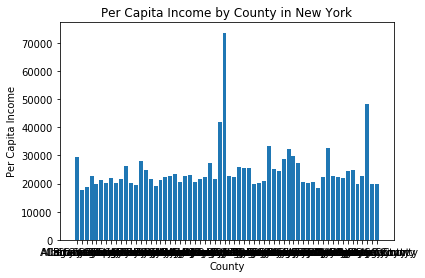

                 0           1           2          3          4
0   New York State  19,542,209  19,378,102  47,126.40     414.68
1    New York City   8,398,748   8,175,133     302.65  27,750.70
2            Bronx   1,432,132   1,385,108      42.10  34,017.39
3            Kings   2,582,830   2,504,700      70.82  36,470.35
4         New York   1,628,701   1,585,873      22.83  71,340.39
..             ...         ...         ...        ...        ...
60      Washington      61,197      63,216     831.18      73.63
61           Wayne      90,064      93,772     603.83     149.15
62     Westchester     967,612     949,113     430.50   2,247.65
63         Wyoming      40,085      42,155     592.75      67.63
64           Yates      24,841      25,348     338.14      73.46

[65 rows x 5 columns]


In [27]:
# PRIYA ----
# Group the data by county and state, and compute the mean of per capita income
grouped_df = df.groupby(['county', 'state']).mean().reset_index()

# Plot a bar graph with the mean per capita income of each county
plt.bar(grouped_df['county'], grouped_df['per_capita_income'])

# Add labels and title to the graph
plt.xlabel('County')
plt.ylabel('Per Capita Income')
plt.title('Per Capita Income by County in New York')

# Show the graph
plt.show()
# Send a request to the URL
url = "https://www.health.ny.gov/statistics/vital_statistics/2018/table02.htm"
response = requests.get(url)

# Parse the HTML content of the page
soup = BeautifulSoup(response.content, "html.parser")

# Find the table containing the data
table = soup.find("table", {"class": "tablepress"})

# Extract the rows of the table
rows = soup.find_all("tr")

# Create an empty list to store the scraped data
data = []

# Loop over each row of the table
for row in rows:
    # Extract the cells of the row
    cells = row.find_all("td")
    
    # If the row has cells, store the data
    if cells:
        data.append([cell.text.strip() for cell in cells])

# Convert the list of data into a Pandas DataFrame
import pandas as pd
df_land = pd.DataFrame(data)

# Changing the headers for df_land :
df_land.to_csv("NY_per_county_area.csv") 


# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("NY_per_county_area.csv")

# Define a dictionary that maps the old header names to the new header names
new_headers = {
    "0": "County",
    "1": "2018 Population Estimate",
    "2": "2010 Census Population",
    "3" : "2010 Land Area Square Miles",
    "4" : "2018 Population Density"
}

# Rename the headers using the `rename` method of the DataFrame
df.rename(columns=new_headers, inplace=True)

# Save the DataFrame back to the CSV file
df.to_csv("NY_per_county_area.csv", index=False)

print(df_land)

In [32]:
# NOTWORKING
# PRIYA ADD Code for latitude and Longitude :
# import requests
# import pandas as pd
# from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame
# import matplotlib.pyplot as plt
def get_address_arcgis(address):
    # Counties latitude and longitude
    url = f"https://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/findAddressCandidates?f=json&singleLine={address}"

response = requests.get(url)

data = response.json()['candidates']
if len(data)!=0:

    latitude = response.json()['candidates'][0]['location']['y']
    longitude = response.json()['candidates'][0]['location']['x']
    

    #print("Latitude: ", latitude)
    #print("Longitude: ", longitude)
    val = {"lat_val":latitude,"long_val":longitude}
    print(val)
    if val:
        return val

# def haversine_distance(lat1,long1,lat2,long2):

#     dist = mpu.haversine_distance((lat1, long1), (lat2, long2))
#     return dist

def read_csv_file(inp_file = r".\Output\Output.csv"):

    df = pd.read_csv(inp_file)
    missing_addr= []
    for idx,row in df.iterrows():
        print(row['Geography'])
        val = get_address_arcgis(address=row['Geography'])

        if val is not None:
            df.loc[idx,'Latitude'] = val['lat_val']
            df.loc[idx,'Longitude'] = val['long_val']
        
        else:
            missing_addr.append(row['Geography'])


df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# calculating the distance
#adf['distance'] = df.apply(lambda row:haversine_distance(row['api_Latitude'],row['api_Longitude'],row['arcgis_Latitude'],row['arcgis_Longitude']))

df.to_csv(inp_file,index = False)

op_file = inp_file.split('.')[0]

with open(op_file+'_'+'missing.txt','w') as f:
    for line in missing_addr:
        f.write(f"{line}\n")
        return "Executed successfully"

read_csv_file()



# # Add lat and long for each county
# url="https://api.geoapify.com/v1/geocode/search?"

# counties=censusonly_popdenscntyland["Geography"]
# longitude=[]
# latitude=[]

# for county in counties:
#     params = {  
#         "text":county,
#         "state":"New York",
#         "apiKey":geoapify_key    
#         }
#     response=requests.get(url,params=params).json()
#     # print(response)
#     longitude.append(response["features"][0]["properties"]["lon"])
#     latitude.append(response["features"][0]["properties"]["lat"])
# print(longitude)
# print(latitude)


# # popdenscountyland["Longitude"]=longitude   
# # popdenscountyland["Latitude"]=latitude

# #CURRENTZEE#

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
popdenscountyland["Longitude"]=longitude   
popdenscountyland["Latitude"]=latitude

In [ ]:
# ZAC - Add dynamic bin slider functionality



In [ ]:
# land_location2=land_location.loc[land_location["Year"]==2020,:]
# land_location2.reset_index()

In [ ]:

# plt.scatter(land_location2['Longitude'],land_location2['Latitude'],c=land_location2['Population Density (person/sq.mi.)'])
# clb = plt.colorbar()
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# clb.set_label("Population Density (person/sq.mi.)")
# plt.show()

In [ ]:
# land_location3=land_location.loc[land_location["Year"]==2010,:]
# land_location3.reset_index()
# prev_yr_pop=land_location3["Population"]
# current_yr_pop=land_location2["Population"]
# pop_growth_percentage=[]

# for pop in prev_yr_pop:
#     for pops in current_yr_pop:
#         population_growth_rate=((current_yr_pop-prev_yr_pop)/prev_yr_pop)*100
#         pop_growth_percentage.append(population_growth_rate)
# print(pop_growth_percentage)

In [ ]:

# land_location2


In [ ]:
# map_plot=land_location2.hvplot.points("Longitude","Latitude",geo=True,tiles="OSM",frame_width=700,frame_height=500, 
#                                     size="Population Density (person/sq.mi.)",color="Geography")

# map_plot